Please see https://docs.google.com/document/d/1PKfTyH9sRCepNbbwP7isleTUXi1DSvZLqNZXbkfw8zQ/edit?tab=t.0

# Solving a Complex Capacity Expansion Model with Benders decomposition

_**[Power Systems Optimization](https://github.com/east-winds/power-systems-optimization)**_


We demonstrate the application of Benders Decomposition to solve the capacity expansion model illustrated in [Complex Capacity Expanion](07-Complex-Capacity-Expansion.ipynb).

In the `complex_expansion_data/` path, we provide several different sets of inputs using different sample time periods, for your use and experimentation, including 10 days (used as default below), 4 weeks, 8 weeks, 16 weeks, and 52 weeks (full 8760 hours). Note that the open-source solver HiGHS may struggle to solve models with more than 10 days. Alter the `inputs_path` parameter below to select a different time series if desired.

## LOAD PACKAGES

In [14]:
# Ensure these packages are installed; if not, use the Pkg package and Pkg.add() function to install
using JuMP

using Plots
using DataFrames, CSV
import Printf

gr(fmt=:png)


using Gurobi
ENV["GRB_LICENSE_FILE"] = "/home/jonah/Dropbox/10 Research/Climate/gurobi.lic"
optimizer = "Gurobi"

# using HiGHS
# optimizer = "HiGHS"

include("benders_cems.jl")

print_iteration (generic function with 1 method)

## SELECT INPUTS PATH

In [15]:
# Read input data for a case with 10 sample days of data
inputs_path = "../complex_expansion_data/10_days/"
# inputs_path = "../complex_expansion_data/4_weeks/"


"../complex_expansion_data/10_days/"

## LOAD INPUTS

In [16]:
inputs = load_inputs(inputs_path);

Scale inputs to improve numerics:

In [17]:
scaling!(inputs)

## GENERATE MONOLITHIC MODEL

In [5]:
Expansion_Model = generate_monolithic_model(inputs, optimizer)

LoadError: Gurobi Error 10009: No Gurobi license found (user jonah, host Mrsha, hostid eeb3c246, cores 12)

### RUN MODEL

In [6]:
## For Step 3: Set just one vCAP linking variable to integer
# set_integer(Expansion_Model[:vCAP][1])
# OR Set all vCAP linking variable to integer
# set_integer.(Expansion_Model[:vCAP])
## What about :vCAP, :vE_CAP, :vT_CAP

monolithic_time = @elapsed optimize!(Expansion_Model)

LoadError: UndefVarError: `Expansion_Model` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [7]:
println("TOOK $(monolithic_time) secs to solve monolothically")

LoadError: UndefVarError: `monolithic_time` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## GENERATE PLANNING MODEL

In [18]:
planning_model = generate_planning_model(inputs, optimizer);

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2558270
Academic license 2558270 - for non-commercial use only - registered to jl___@princeton.edu


## GENERATE OPERATION MODELS

In [19]:
operation_models = generate_decomposed_operation_models(inputs, optimizer);

println("# Operation models= $(length(operation_models))")

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2558270
Academic license 2558270 - for non-commercial use only - registered to jl___@princeton.edu
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2558270
Academic license 2558270 - for non-commercial use only - registered to jl___@princeton.edu
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2558270
Academic license 2558270 - for non-commercial use only - registered to jl___@princeton.edu
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2558270
Academic license 2558270 - for non-commercial use only - registered to jl___@princeton.edu
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2558270
Academic license 2558270 - for non-commercial use only - registered to jl___@princeton.edu
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2558270

In [20]:
# Don't go much over 1e-4 or -5
# Will need to restart the kernel to run it (Gurobi Caches it)
tol = 1e-2


## For Step 3: Set just one vCAP linking variable to integer
# set_integer(planning_model[:vCAP][1])
# OR Set all vCAP linking variable to integer
# set_integer.(planning_model[:vCAP])
## What about :vCAP, :vE_CAP, :vT_CAP


@time benders_solution = benders_iterations(50,
                            planning_model,operation_models, optimizer;
                            tol=tol, verbose=false);

Iteration  Lower Bound  Upper Bound          Gap
..........        1   0.0000e+00   3.8163e+06          Inf
..........        2   4.9141e+02   3.5552e+06   7.2336e+03
..........        3   5.8963e+02   4.4874e+04   7.5104e+01
..........        4   1.5501e+03   1.6679e+04   9.7604e+00
..........        5   3.1113e+03   1.6679e+04   4.3610e+00
..........        6   3.4119e+03   1.6679e+04   3.8887e+00
..........        7   3.5023e+03   1.6679e+04   3.7624e+00
..........        8   4.2765e+03   1.6679e+04   2.9003e+00
..........        9   5.3890e+03   1.6679e+04   2.0951e+00
..........       10   5.5121e+03   1.6550e+04   2.0024e+00
..........       11   6.6663e+03   1.3793e+04   1.0690e+00
..........       12   7.6123e+03   1.0758e+04   4.1319e-01
..........       13   8.7338e+03   1.0758e+04   2.3173e-01
..........       14   8.7663e+03   1.0758e+04   2.2715e-01
..........       15   9.1744e+03   1.0408e+04   1.3444e-01
..........       16   9.4187e+03   1.0408e+04   1.0502e-01
.......

[ Info: Convergence tolerance satisfied! (gap = 0.0070105445011409626) !


  5.099112 seconds (14.60 M allocations: 742.620 MiB, 6.82% gc time, 76.75% compilation time)


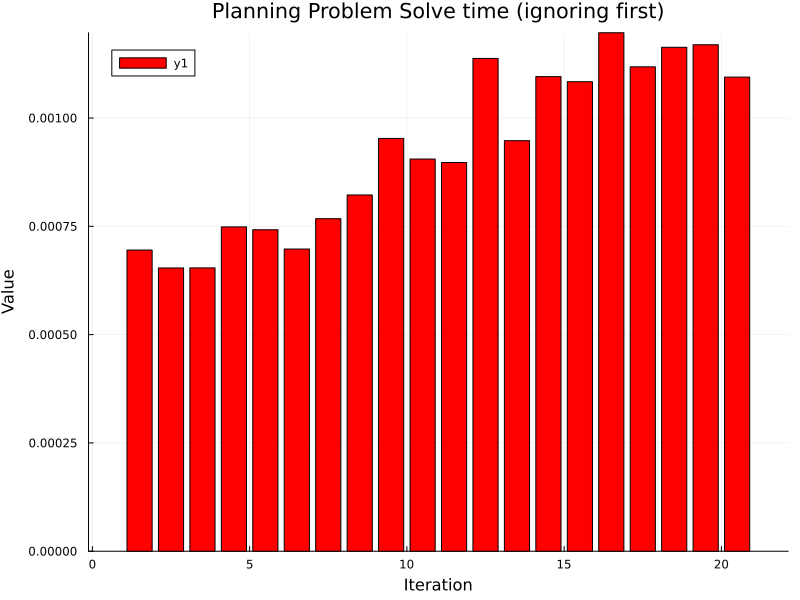

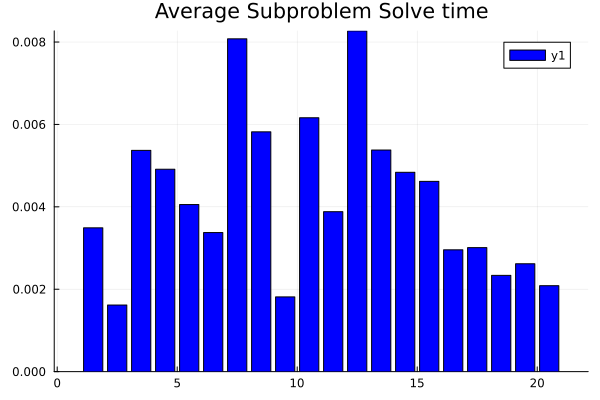

In [22]:
# Plots the solution time per iteration for master and subproblems

n = length(benders_solution.ops_times)



# Create the plot
p = plot(
    (1:length(benders_solution.planning_times)),
    (benders_solution.planning_times)[2:end],
    seriestype = :bar,
    color = :red,
    title = "Planning Problem Solve time (ignoring first)",
    bar_width = 0.8, # Adjust bar width as needed
    xlabel = "Iteration",
    ylabel = "Value",
    legend = :topleft,
    # yscale = :log10,
    size = (800, 600),
)
display(p)

plot(
    (1:length(benders_solution.ops_times)),
    ((benders_solution.ops_times ./ length(operation_models)))[2:end],
    seriestype = :bar,
    color = :blue,
    title = "Average Subproblem Solve time",
    bar_width = 0.8,
    # yscale = :log10,
)

In [12]:
# The capacity values in the benders and monolithic modesl
benders_solution.vCAP.data[1:10] |> println

# Monolithic, run above
value.(Expansion_Model[:vCAP]).data[1:10] |> println

LoadError: UndefVarError: `benders_solution` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [13]:
function niceLog10(x)
    if x == 0
        x = 1e-3
    end
    x |> abs |> log10
    # Can make this not log10 if want to examine the large values over small ones
    # x |> abs
end

gr(fmt=:png)
x_points = niceLog10.(benders_solution.vCAP.data)
y_points = niceLog10.(value.(Expansion_Model[:vCAP]).data)
scatter(x_points, y_points,
    label="Points", xlabel="Benders Solution", ylabel = "Monolithic Solution",
    title="Benders vs Monolithic Solution (log10)")
plot!(x -> x, minimum(x_points), maximum(x_points), label="y=x")

LoadError: UndefVarError: `benders_solution` not defined in `Main`
Suggestion: check for spelling errors or missing imports.